# House Prices: Advanced Regression Techniques

このノートブックでは
[House Pricesコンペティション](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
を題材にして家の特徴から販売価格の予測を行います。

今回のノートブックの目的はデータ分析からモデリングまでの一連の流れを体験することです。

ハイスコアを求める方は他のノートブックを参照ください。

ノートブックは下記の流れで進めます。

1. 問題定義
1. データを用意する
1. 前処理 
1. データの分析
1. モデル作成
1. 可視化して報告する。


## 1.問題定義

今回の目的は家の特徴（築年数、面積など）から販売価格を精度良く予測することです。

最終的なスコアは[Root-Mean-Squared-Error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation)で算出します。


## 2.データ

[データ](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)はコンペティションで用意されたデータを使います。

まずデータを読み込みます。

In [1]:
# 必要なモジュールを用意します。
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_path = '../input/'
train_df = pd.read_csv(data_path + 'train.csv')
test_df = pd.read_csv(data_path + 'test.csv')

データの大きさを見てみましょう。

In [3]:
train_df.shape

(1460, 81)

1460データありますが、そこまで大きなデータではありません。  
また81個の特徴があります。

次にデータを数件見てみましょう。

In [4]:
pd.set_option("display.max_columns", 100) # 列の最大表示件数を100件にする。 デフォルトは50件
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


カテゴリーデータや数値データに欠損値があります。  

## 3.前処理

今回は線形回帰型の問題なのでモデリングのために各変数を欠損値のない数値データに変換する必要があります。

まずは欠損値を対処するため、欠損値のある特徴量を表示します。

In [5]:
for line in train_df.columns:
    null_num = train_df[line].isnull().sum()
    if null_num > 0:
        print(line+"："+str(train_df[line].isnull().sum())+"（"+str(train_df[line].dtype)+")")

LotFrontage：259（float64)
Alley：1369（object)
MasVnrType：8（object)
MasVnrArea：8（float64)
BsmtQual：37（object)
BsmtCond：37（object)
BsmtExposure：38（object)
BsmtFinType1：37（object)
BsmtFinType2：38（object)
Electrical：1（object)
FireplaceQu：690（object)
GarageType：81（object)
GarageYrBlt：81（float64)
GarageFinish：81（object)
GarageQual：81（object)
GarageCond：81（object)
PoolQC：1453（object)
Fence：1179（object)
MiscFeature：1406（object)


ここから各変数を線形回帰問題で使える変数にするため、前処理で下記の処理を行います。

- 欠損値の対処
- カテゴリーデータを数値データに変換


In [6]:
for df in [train_df, test_df]:
    for col in df.columns:
        if df[col].dtype == 'object':
            # convet nan to 'NullObject' and convert value to unique numeric value
            df[col] = df[col].fillna("NullObject")
            df[col] = df[col].map({ x : i for i, x in enumerate(np.unique(df[col]))})
        else:
            # convert nan to colmun's mean value
            df[col] = df[col].fillna(df[col].mean())

処理できたか確認します。

In [7]:
print('null count for train_df : ' + str(train_df.isnull().sum().sum()))
print('null count for test_df : ' + str(test_df.isnull().sum().sum()))

null count for train_df : 0
null count for test_df : 0


In [8]:
pd.set_option("display.max_columns", 100) # 列の最大表示件数を100件にする。 デフォルトは50件
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,1,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,196.0,2,4,2,2,4,3,2,706,6,0,150,856,1,0,1,5,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,3,1,2003.0,2,2,548,5,5,2,0,61,0,0,0,0,3,4,1,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,1,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.0,3,4,1,2,4,1,0,978,6,0,284,1262,1,0,1,5,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,5,1,1976.0,2,2,460,5,5,2,298,0,0,0,0,0,3,4,1,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,1,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,162.0,2,4,2,2,4,2,2,486,6,0,434,920,1,0,1,5,920,866,0,1786,1,0,2,1,3,1,2,6,6,1,5,1,2001.0,2,2,608,5,5,2,0,42,0,0,0,0,3,4,1,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,1,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,2,0.0,3,4,0,4,1,3,0,216,6,0,540,756,1,2,1,5,961,756,0,1717,1,0,1,0,3,1,2,7,6,1,2,5,1998.0,3,3,642,5,5,2,0,35,272,0,0,0,3,4,1,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,1,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,1,350.0,2,4,2,2,4,0,2,655,6,0,490,1145,1,0,1,5,1145,1053,0,2198,1,0,2,1,4,1,2,9,6,1,5,1,2000.0,2,3,836,5,5,2,192,84,0,0,0,0,3,4,1,0,12,2008,8,4,250000


In [9]:
for df in [train_df, test_df]:
    for col in df.columns:
        if df[col].dtype == 'object':
            print("Category column exist!!!!")
else:
    print('There is no category column. ')

There is no category column. 


すべてのカテゴリーデータが数値データに置き換わっていることが確認できました。

## 4. データの分析

データが準備できたので、実際に分析に入ります。
今回は目的変数との相関関係を見ることにします。

SalePriceと相関が高い上位１０個の特徴をヒートマップで表示します。

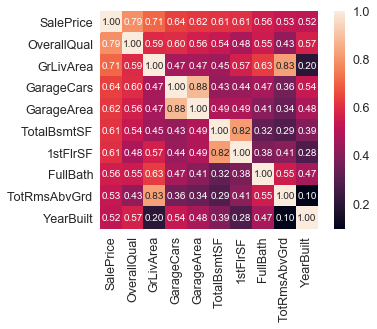

In [10]:
# 販売価格との相関行列（ヒートマップ）
corrmat = train_df.corr()
k =10 # 変数の数
# 関数の意味を記述する nlargest 大きい順にいくつかとる <->nsmallest 
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
# 販売価格との相関係数が大きい順に10個並べて、そのインデックスをcolsに代入　
cm = np.corrcoef(train_df[cols].values.T)# 販売価格との相関係数が大きい順１０項目の値で再度相関係数をとる
# なぜ転置をとるのか http://lofas.hatenablog.com/entry/2015/02/09/150552
sns.set(font_scale=1.25) # 項目の名前のフォントを1.25倍する
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

ここからモデル学習する特徴を選択します。
GarageCarsとGarageAreaの変数は0.88と正の相関が強く、
ガレージに駐車できる車の数とガレージの面積は同じことを説明しています。
そのためGarageAreaを省きます。
また目的変数であるSalePriceも省きます。

In [11]:
cols = cols.drop('GarageArea')
cols = cols.drop('SalePrice')
cols

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF',
       'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')

## 6.モデル作成

学習する特徴を選択したところでいよいよモデル学習と評価に入ります。
さきほど選択した販売価格に影響しそうな8個の項目を使ってモデル学習を行います。

たくさん予測モデルアルゴリズムが選択肢としてありますが、今回は教師あり学習で回帰問題です。 
 これらの２つの観点（教師あり学習、分類と回帰）から以下の９つに絞ります。

- ロジスティック回帰
- K近傍法
- サポートベクターマシン
- ナイーブベイズ分類
- 決定木
- ランダムフォレスト
- パーセプトロン
- 人工ニューラルネットワーク
- 関連ベクターマシン

つぎにデータを用意します。

In [12]:
# 目的変数以外をトレーニングデータとする
X = train_df[cols]
# SalePriceを目的変数とする
Y = train_df['SalePrice']
# テストデータの必要な項目
X_test = test_df[cols]
# 項目数がテストとトレーニングセットで同じか確認する
X.shape, Y.shape ,X_test.shape

((1460, 8), (1460,), (1459, 8))

In [13]:
# 機械学習アルゴリズムモジュールをインポート
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [14]:
model_dict = {
    "LogisticRegression": LogisticRegression(),
    "SVM" : SVC(),
    "KNN" : KNeighborsClassifier(n_neighbors = 3),
    "Gaussian" : GaussianNB(),
    'Perceptron' : Perceptron(),
    'Linear SVC'  : LinearSVC(),
    'Stochastic Gradient Descent' : SGDClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest' : RandomForestClassifier(n_estimators=100),
}

In [15]:
import sklearn.cross_validation as cross_validation
from sklearn.metrics import mean_squared_error
import math


best_score = 10000000000000
best_model = ""

for model_name, model_instance in model_dict.items():
    rmse_score = []
    for rand_seed in range(5):
        X_train, X_valid, Y_train, Y_valid = cross_validation.train_test_split(X, Y, test_size=0.2, random_state=rand_seed)
        model_instance.fit(X_train, Y_train)
        Y_pred = model_instance.predict(X_valid)
        rmse_score.append(math.sqrt(mean_squared_error(Y_valid, Y_pred)/ len(Y_valid)))
        
    average_score = sum(rmse_score) / len(rmse_score) 
    print(model_name + "'s average score : {}".format(round(average_score) ))
    if average_score < best_score:
        best_score = average_score
        best_model = model_name

print("Best model is " + best_model )
print(round(best_score))

/Users/kzfm/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


LogisticRegression's average score : 3016
SVM's average score : 5146
KNN's average score : 3366
Gaussian's average score : 2764


/Users/kzfm/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Perceptron's average score : 5771
Linear SVC's average score : 4958


/Users/kzfm/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Stochastic Gradient Descent's average score : 5223
Decision Tree's average score : 2638
Random Forest's average score : 2203
Best model is Random Forest
2203


今回のベストモデルは**ランダムフォレスト**です。
そのためランダムフォレストモデルを使って予測値を出します。

In [16]:
Y_pred = model_dict['Random Forest'].predict(X_test)

下記は提出用のコードになります。
コメントアウトを外して実行するとカレントディレクトリ上にsubmission.csvファイルが作成されます。

In [17]:
# 提出の仕方
submission = pd.DataFrame({
       "Id": test_df["Id"],
       "SalePrice": Y_pred
   })
# 下記のコードで実際に提出するcsvファイルを作成できる
# submission.to_csv("./submission.csv", index=False)

## まとめ

ここまでざっとデータ分析の一連の手順を行いました。

- ランダムフォレストが9つのモデルで最もよいスコアが出る。
- 目的変数と最も相関が強かったの上位５つは下記５つの特徴になる。
    - 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF',

ただしあまりスコアは出ませんでした。
※スコア0.21064 2018/4/30時点で4558位

より良いスコアを出すための改善点は下記になります。

## 反省点

- 前処理
    - カテゴリーデータを機械的に数値に置き換えてしまった。本来は項目ごとに順序があるような項目はより適切な数字に置き換える必要がある。
- 特徴量エンジニアリング
    - 与えられた特徴だけでなく、面積系の特徴の合計面積を一つの特徴として加える。
    - 相関係数だけでなく与えられたドメイン知識を使って仮説を立てる。
- 検証
    - 検証の仕方を交差検証に切り替える。
- ランダムフォレスト
    - ランダムフォレストが特徴量を選んでくれるので使う特徴量を8個に絞らず、もっと多めにモデルに渡す。
    - グリッドサーチでパラメータチューニングを行う。


# 質問やコメントは大歓迎です。